In [17]:
import sys 
import os 
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
sys.path.append('../')

In [18]:
from src.utils.quantizer import Normalizer
from src.linear_compress import LinearQuantizedSparse

In [19]:
# linear_layer = "layer_1/mlp.up_proj"
with torch.no_grad():
    linear_layer = "layer_0/self_attn.q_proj"
    weight = f"/data/lliu/huffman/models/meta-llama/Llama-2-7b-hf/original_weights/{linear_layer}.pt"
    hessian = f"/data/lliu/huffman/models/meta-llama/Llama-2-7b-hf/hessians_new/seed_0/pajama/128/{linear_layer}.pt"


    weight = torch.load(weight, map_location='cpu')["weight"].detach()
    _,weight_normalized = Normalizer.normalize_init(weight, [0,1], [False,False],norm_rescale=True, powers=1)
    hessian = torch.load(hessian, map_location='cpu')["hessian"]

    threshold = 1
    if threshold<1:

        weight_thresh = np.percentile(np.abs(weight), threshold*100)
        #clip the weight
        weight = np.clip(weight, -weight_thresh, weight_thresh)


        weight_thresh = np.percentile(np.abs(weight_normalized), threshold*100)
        #clip the weight
        weight_normalized = np.clip(weight_normalized, -weight_thresh, weight_thresh)


    d_out, d_in = weight.shape

/tmp/ipykernel_1095222/1445205299.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(weight, map_location='cpu')["weight"].detach()
/tmp/ipykernel_10952

In [20]:
#measure the mu incovariance
mu_w = torch.max(torch.abs(weight))*np.sqrt(np.prod(weight.shape))/torch.norm(weight)
mu_w_norm = torch.max(torch.abs(weight_normalized))*np.sqrt(np.prod(weight_normalized.shape))/torch.norm(weight_normalized)

print(f"mu_w: {mu_w}")
print(f"mu_w_norm: {mu_w_norm}")

mu_w: 57.375
mu_w_norm: 11.875


In [21]:
#try to use PCA to reduce the dimensionality
d= 6

#pad the weight and weight_normalized to make it divisible by d
d_in_pad = d_in + d - d_in%d
print(weight.shape)
weight = np.pad(weight, ((0,0),(0,d_in_pad-d_in)), mode='constant', constant_values=0)
print(weight.shape)
weight_normalized = np.pad(weight_normalized, ((0,0),(0,d_in_pad-d_in)), mode='constant', constant_values=0)

weight_d = weight.reshape(-1, d)
weight_normalized_d = weight_normalized.reshape(-1, d)

torch.Size([4096, 4096])
(4096, 4098)


In [22]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components=d)

weight_2d = pca.fit_transform(weight_d)

weight_normalized_2d = pca.fit_transform(weight_normalized_d)

In [23]:
#get the weights as a 2d array 
# weight_2d = weight.reshape(-1,2)

# weight_normalized_2d = weight_normalized.reshape(-1,2)

# #get the two histograms

# H_w,x_w,y_w = np.histogram2d(weight_2d[:,0], weight_2d[:,1], bins=400,density=True)
# H_w = H_w.T

# H_norm,x_norm,y_norm = np.histogram2d(weight_normalized_2d[:,0], weight_normalized_2d[:,1], bins=400,density=True)
# H_norm = H_norm.T


In [24]:
H_w,x_w,y_w = np.histogram2d(weight_2d[:,0], weight_2d[:,1], bins=400,density=True)
H_w = H_w.T

H_norm,x_norm,y_norm = np.histogram2d(weight_normalized_2d[:,0], weight_normalized_2d[:,1], bins=400,density=True)
H_norm = H_norm.T

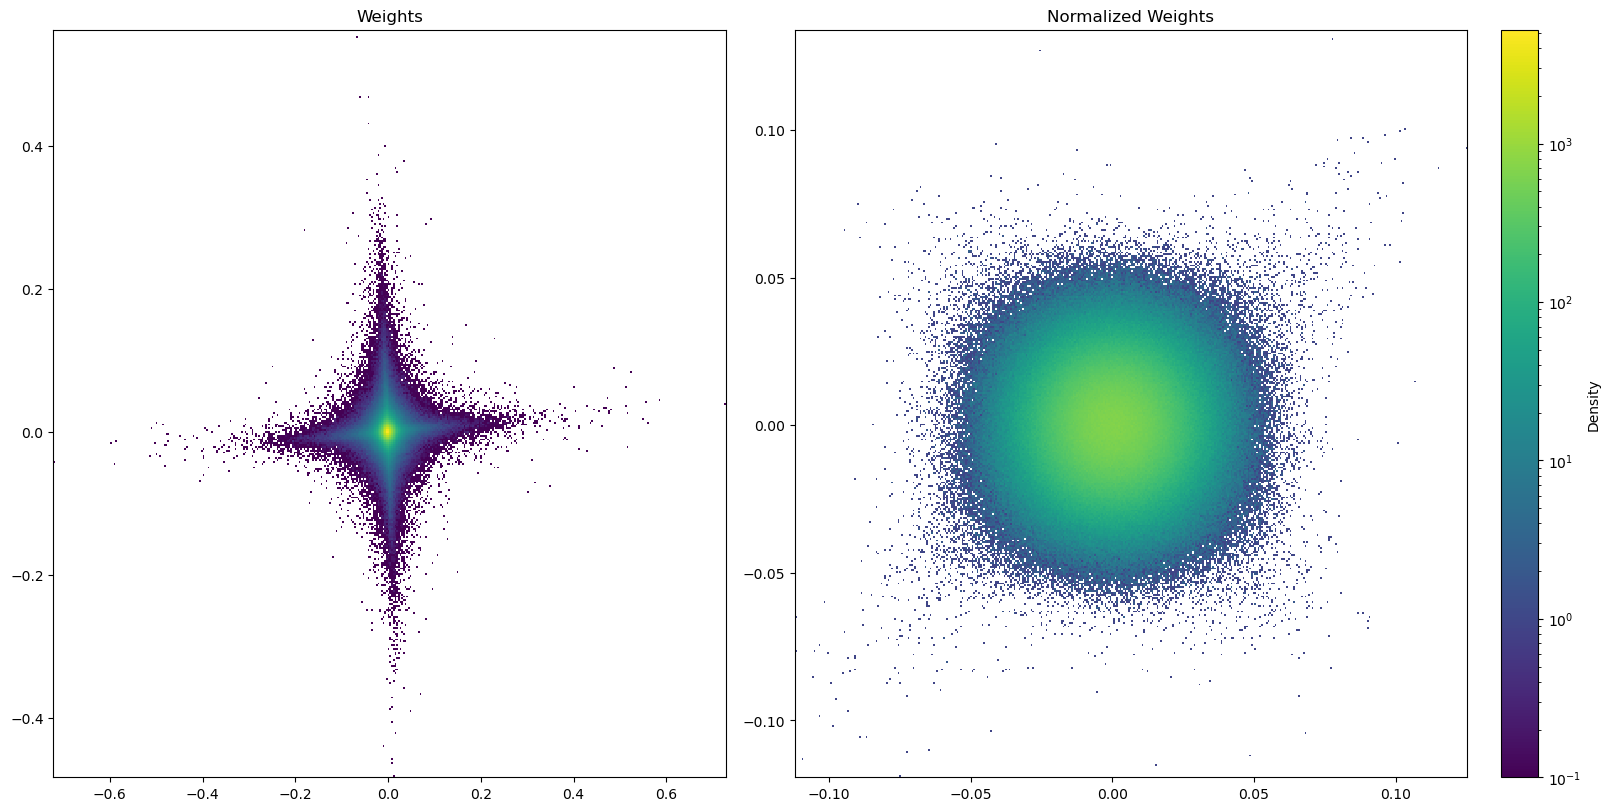

In [25]:
size = 8
fig,axs = plt.subplots(1,2, figsize=(size*2,size), constrained_layout=True
                        # sharex=True, sharey=True
                        )

norm = mcolors.LogNorm(vmin=max(min(H_w.min(), H_norm.min()),1e-1), vmax=max(H_w.max(), H_norm.max()), clip=False)
plt.sca(axs[0])
plt.title("Weights")
plt.imshow(H_w, extent=(x_w.min(), x_w.max(), y_w.min(), y_w.max()), origin='lower', interpolation='nearest',
           aspect="auto", norm=norm, cmap='viridis')
# plt.colorbar()

plt.sca(axs[1])
plt.title("Normalized Weights")
plt.imshow(H_norm, extent=(x_norm.min(), x_norm.max(), y_norm.min(), y_norm.max()), origin='lower', interpolation='nearest',
           aspect="auto", norm=norm)

colorbar = plt.colorbar()
colorbar.set_label("Density")

plt.savefig("weight_distribution.png")

/tmp/ipykernel_1055820/3693937209.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(H_norm), extent=(x_norm.min(), x_norm.max(), y_norm.min(), y_norm.max()), origin='lower',cmap = "Greys")


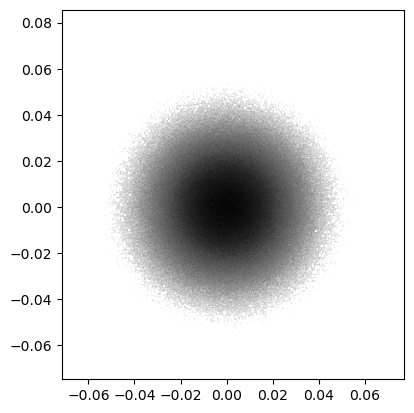

In [10]:
plt.imshow(np.log(H_norm), extent=(x_norm.min(), x_norm.max(), y_norm.min(), y_norm.max()), origin='lower',cmap = "Greys")